# 주차 수요예측

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 글꼴깨짐 방지
import matplotlib
import matplotlib.font_manager as fm

fm.get_fontconfig_fonts()
font_location = 'C:/Windows/Fonts/malgun.ttf' # For Windows
font_name = fm.FontProperties(fname=font_location).get_name()
matplotlib.rc('font', family=font_name)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: MatplotlibDeprecationWarning: 
The get_fontconfig_fonts function was deprecated in Matplotlib 3.5 and will be removed two minor releases later.
  if __name__ == '__main__':


In [2]:
train = pd.read_csv('train.csv')
train.head()

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수
0,C2483,900,아파트,경상북도,국민임대,39.72,134,38.0,A,15667000,103680,0.0,3.0,1425.0,1015.0
1,C2483,900,아파트,경상북도,국민임대,39.72,15,38.0,A,15667000,103680,0.0,3.0,1425.0,1015.0
2,C2483,900,아파트,경상북도,국민임대,51.93,385,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0
3,C2483,900,아파트,경상북도,국민임대,51.93,15,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0
4,C2483,900,아파트,경상북도,국민임대,51.93,41,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0


In [3]:
train.rename(columns = {'도보 10분거리 내 지하철역 수(환승노선 수 반영)':'지하철','도보 10분거리 내 버스정류장 수':'버스'},inplace=True)

In [4]:
train.corr()

,총세대수,전용면적,전용면적별세대수,공가수,지하철,버스,단지내주차면수,등록차량수
총세대수,1.000000,0.042271,0.098205,0.068192,0.213843,-0.001446,0.501488,0.316703
전용면적,0.042271,1.000000,-0.035479,-0.089201,-0.013111,-0.007866,0.071260,0.115453
전용면적별세대수,0.098205,-0.035479,1.000000,0.166472,-0.056680,0.047112,0.281989,0.247085
공가수,0.068192,-0.089201,0.166472,1.000000,-0.093334,0.043285,0.289819,0.118121
지하철,0.213843,-0.013111,-0.056680,-0.093334,1.000000,0.098380,-0.055544,-0.108592
버스,-0.001446,-0.007866,0.047112,0.043285,0.098380,1.000000,0.070696,0.103752
단지내주차면수,0.501488,0.071260,0.281989,0.289819,-0.055544,0.070696,1.000000,0.859216
등록차량수,0.316703,0.115453,0.247085,0.118121,-0.108592,0.103752,0.859216,1.000000


In [5]:
# 오류 단지코드가 존재하는 행들을  사전에 제거
train_error = ['C2085', 'C1397', 'C2431', 'C1649', 'C1036', 'C1095', 'C2051', 'C1218', 'C1894', 'C2483', 'C1502', 'C1988']
train = train[~train['단지코드'].isin(train_error)].reset_index(drop=True)

## 컬럼 정보

 00. **단지코드**
 01. **총세대수**
 02. **임대건물구분**: 상가, 아파트에 해당 <br>
 03. **지역**: 인천을 제외한 16개 시도 <br>
 04. **공급유형**
     - 국민임대: 30년간의 임대기간이고 분양전환이 되지 않습니다
     - 공공임대: 임대기간을 5년,10년등으로 모집 공고시 결정하여 공급하며 임대 기간이후 입주자 우선으로 분양 전환을 합니다.
     - 영구임대: 영구히 임대만 합니다.해당 지자체에 영구임대가 있는경우 신규 공급은 하지 않습니다.
     - 장기전세: 월 임대료를 지불하지 않고 전세계약 방식으로 공급되는 공공임대주택
     - 행복주택: 청년(19세∼39세·신혼부부·대학생 등 젊은계층)의 주거불안 해소를 위해 주변시세보다 저렴하게 공급하는 공공임대주택
 05. **전용면적** <br>
 06. **전용면적별세대수** <br>
 07. **공가수**: 총세대수 - 현재거주세대수 <br>
 08. **자격유형: 파악X** <br>
 09. **임대보증금** <br>
 10. **임대료** <br>
 11. **도보 10분거리 내 지하철역 수(환승노선 수 반영)** <br>
 12. **도보 10분거리 내 버스정류장 수** <br>
 13. **단지내주차면수** <br>
 14. **등록차량수**

In [6]:
# 사용하지 않을 컬럼 drop
train.drop('자격유형',axis = 1,inplace=True)

## 기초 통계량 확인

In [7]:
train.shape

(2869, 14)

In [8]:
train.info() # 임대보증금, 임대료 type object라서 나중에 float으로 형변환

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2869 entries, 0 to 2868
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   단지코드      2869 non-null   object 
 1   총세대수      2869 non-null   int64  
 2   임대건물구분    2869 non-null   object 
 3   지역        2869 non-null   object 
 4   공급유형      2869 non-null   object 
 5   전용면적      2869 non-null   float64
 6   전용면적별세대수  2869 non-null   int64  
 7   공가수       2869 non-null   float64
 8   임대보증금     2300 non-null   object 
 9   임대료       2300 non-null   object 
 10  지하철       2662 non-null   float64
 11  버스        2869 non-null   float64
 12  단지내주차면수   2869 non-null   float64
 13  등록차량수     2869 non-null   float64
dtypes: float64(6), int64(2), object(6)
memory usage: 313.9+ KB


## 결측치 여부

In [9]:
train[(train['임대건물구분']=='상가')&(train['지역']=='경상남도')]

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,임대보증금,임대료,지하철,버스,단지내주차면수,등록차량수
125,C2416,560,상가,경상남도,임대상가,19.69,1,0.0,NaN,NaN,0.0,5.0,154.0,63.0
126,C2416,560,상가,경상남도,임대상가,27.12,1,0.0,NaN,NaN,0.0,5.0,154.0,63.0
127,C2416,560,상가,경상남도,임대상가,32.54,1,0.0,NaN,NaN,0.0,5.0,154.0,63.0
128,C2416,560,상가,경상남도,임대상가,36.43,1,0.0,NaN,NaN,0.0,5.0,154.0,63.0
129,C2416,560,상가,경상남도,임대상가,46.89,1,0.0,NaN,NaN,0.0,5.0,154.0,63.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
826,C2571,481,상가,경상남도,임대상가,31.84,1,5.0,NaN,NaN,0.0,1.0,65.0,62.0
827,C2571,481,상가,경상남도,임대상가,31.84,1,5.0,NaN,NaN,0.0,1.0,65.0,62.0
828,C2571,481,상가,경상남도,임대상가,31.84,1,5.0,NaN,NaN,0.0,1.0,65.0,62.0
829,C2571,481,상가,경상남도,임대상가,31.84,1,5.0,NaN,NaN,0.0,1.0,65.0,62.0


In [10]:
train[(train['임대건물구분']=='상가')]

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,임대보증금,임대료,지하철,버스,단지내주차면수,등록차량수
80,C1925,601,상가,강원도,임대상가,32.10,1,9.0,NaN,NaN,0.0,4.0,117.0,75.0
81,C1925,601,상가,강원도,임대상가,32.10,1,9.0,NaN,NaN,0.0,4.0,117.0,75.0
82,C1925,601,상가,강원도,임대상가,32.10,1,9.0,NaN,NaN,0.0,4.0,117.0,75.0
83,C1925,601,상가,강원도,임대상가,72.16,1,9.0,NaN,NaN,0.0,4.0,117.0,75.0
93,C1874,619,상가,충청남도,임대상가,12.62,1,2.0,NaN,NaN,NaN,2.0,97.0,62.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
826,C2571,481,상가,경상남도,임대상가,31.84,1,5.0,NaN,NaN,0.0,1.0,65.0,62.0
827,C2571,481,상가,경상남도,임대상가,31.84,1,5.0,NaN,NaN,0.0,1.0,65.0,62.0
828,C2571,481,상가,경상남도,임대상가,31.84,1,5.0,NaN,NaN,0.0,1.0,65.0,62.0
829,C2571,481,상가,경상남도,임대상가,31.84,1,5.0,NaN,NaN,0.0,1.0,65.0,62.0


In [11]:
train[(train['임대건물구분']=='상가')].isnull().sum()

단지코드          0
총세대수          0
임대건물구분        0
지역            0
공급유형          0
전용면적          0
전용면적별세대수      0
공가수           0
임대보증금       562
임대료         562
지하철         127
버스            0
단지내주차면수       0
등록차량수         0
dtype: int64

In [12]:
# 결측치 확인
train.isnull().sum()

단지코드          0
총세대수          0
임대건물구분        0
지역            0
공급유형          0
전용면적          0
전용면적별세대수      0
공가수           0
임대보증금       569
임대료         569
지하철         207
버스            0
단지내주차면수       0
등록차량수         0
dtype: int64

In [13]:
train.groupby('임대건물구분')[['등록차량수']].sum()

,등록차량수
임대건물구분,
상가,89017.0
아파트,1489299.0


In [14]:
# 결측치가 존재하는 특정 행 살펴보기
# df.loc[df['컬럼명'].isnull()]
임대보증금_null = train.loc[train['임대보증금'].isnull()]
임대보증금_null.tail(15)

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,임대보증금,임대료,지하철,버스,단지내주차면수,등록차량수
823,C2571,481,상가,경상남도,임대상가,31.84,1,5.0,NaN,NaN,0.0,1.0,65.0,62.0
824,C2571,481,상가,경상남도,임대상가,31.84,1,5.0,NaN,NaN,0.0,1.0,65.0,62.0
825,C2571,481,상가,경상남도,임대상가,31.84,1,5.0,NaN,NaN,0.0,1.0,65.0,62.0
826,C2571,481,상가,경상남도,임대상가,31.84,1,5.0,NaN,NaN,0.0,1.0,65.0,62.0
827,C2571,481,상가,경상남도,임대상가,31.84,1,5.0,NaN,NaN,0.0,1.0,65.0,62.0
828,C2571,481,상가,경상남도,임대상가,31.84,1,5.0,NaN,NaN,0.0,1.0,65.0,62.0
829,C2571,481,상가,경상남도,임대상가,31.84,1,5.0,NaN,NaN,0.0,1.0,65.0,62.0
830,C2571,481,상가,경상남도,임대상가,126.65,1,5.0,NaN,NaN,0.0,1.0,65.0,62.0
2284,C1350,1401,아파트,대전광역시,공공분양,74.94,317,2.0,NaN,NaN,NaN,6.0,1636.0,2315.0
2285,C1350,1401,아파트,대전광역시,공공분양,74.94,137,2.0,NaN,NaN,NaN,6.0,1636.0,2315.0


In [15]:
print(임대보증금_null['공급유형'].unique(),'\n')
print(len(임대보증금_null['공급유형']))

['임대상가' '공공분양'] 

569


In [16]:
print('전체 단지 수',len(train['단지코드'].unique()))

전체 단지 수 411


In [17]:
#임대보증금_null[임대보증금_null['공급유형']=='임대상가']['단지코드'].unique()

In [18]:
print('결측치가 존재하는 단지 수',len(임대보증금_null[임대보증금_null['공급유형']=='임대상가']['단지코드'].unique()))

결측치가 존재하는 단지 수 33


In [19]:
33/411*100

8.02919708029197

In [20]:
# 임대상가
# 공공분야의 경우, 한 아파트 단지가 결측치라 drop을 해도 예측에 있어 문제가 없다고 판단
print('임대상가_Null: ',len(임대보증금_null[임대보증금_null['공급유형']=='임대상가']))
print('공공분양_Null: ',len(임대보증금_null[임대보증금_null['공급유형']=='공공분양']))

임대상가_Null:  562
공공분양_Null:  7


In [21]:
#train.dropna(axis = 0,inplace=True)
train.isnull().sum()

단지코드          0
총세대수          0
임대건물구분        0
지역            0
공급유형          0
전용면적          0
전용면적별세대수      0
공가수           0
임대보증금       569
임대료         569
지하철         207
버스            0
단지내주차면수       0
등록차량수         0
dtype: int64

## 범주형 변수

In [22]:
# 임대보증금과 임대료는 train.info()에서 확인했듯이 형변환하기
# 다른 컬럼들은 하나씩 뜯어보면서 이해해 볼 예정
for column_type in train.columns:
    if train[column_type].dtype == 'O':
        print('컬럼명: ', column_type)
        print('nunique: ',train[column_type].nunique(),'\n')

컬럼명:  단지코드
nunique:  411 

컬럼명:  임대건물구분
nunique:  2 

컬럼명:  지역
nunique:  16 

컬럼명:  공급유형
nunique:  10 

컬럼명:  임대보증금
nunique:  926 

컬럼명:  임대료
nunique:  965 



### 단지코드

- 차후 인덱스로 활용하기 위해 일단 패스

### 임대건물구분

In [23]:
# 어차피 아파트 하나라서 컬럼에서 삭제
train['임대건물구분'].unique()

array(['아파트', '상가'], dtype=object)

### 지역

In [24]:
train['지역'].unique() # 17개 시도이지만, 인천광역시가 존재하지 않음

array(['경상남도', '대전광역시', '경기도', '전라북도', '강원도', '광주광역시', '충청남도', '부산광역시',
       '제주특별자치도', '울산광역시', '충청북도', '전라남도', '경상북도', '대구광역시', '서울특별시',
       '세종특별자치시'], dtype=object)

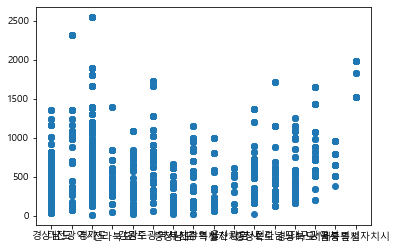

In [25]:
plt.scatter(train['지역'], train['등록차량수'])

In [26]:
print(train.groupby('지역')[['등록차량수']].sum(),'\n')
print(train.groupby('지역')[['등록차량수']].sum().sum())

            등록차량수
지역               
강원도       72602.0
경기도      474453.0
경상남도     148716.0
경상북도      68138.0
광주광역시    103192.0
대구광역시     89099.0
대전광역시    142415.0
부산광역시    103827.0
서울특별시     34139.0
세종특별자치시   42857.0
울산광역시     11462.0
전라남도      74923.0
전라북도      52584.0
제주특별자치도   30323.0
충청남도      37787.0
충청북도      91799.0 

등록차량수    1578316.0
dtype: float64


### 공급유형

In [27]:
train['공급유형'].unique()

array(['국민임대', '공공임대(50년)', '영구임대', '임대상가', '공공임대(10년)', '공공임대(분납)',
       '장기전세', '공공분양', '행복주택', '공공임대(5년)'], dtype=object)

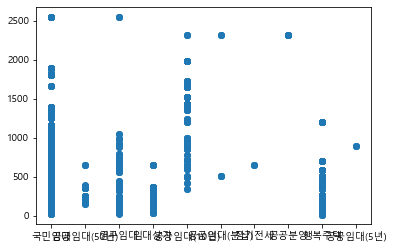

In [28]:
plt.scatter(train['공급유형'], train['등록차량수'])

In [29]:
print(train.groupby('공급유형')[['등록차량수']].sum(),'\n')
print(train.groupby('공급유형')[['등록차량수']].sum().sum())

               등록차량수
공급유형                
공공분양         16205.0
공공임대(10년)   211600.0
공공임대(50년)     9739.0
공공임대(5년)      2661.0
공공임대(분납)      8981.0
국민임대       1108937.0
영구임대         57781.0
임대상가         89017.0
장기전세          1935.0
행복주택         71460.0 

등록차량수    1578316.0
dtype: float64


### 임대보증금, 임대료

In [30]:
# 수치형 데이터로 변환
print('변환 전')
print('임대보증금: ',train['임대보증금'].dtype,'임대료: ',train['임대료'].dtype)

train[['임대보증금', '임대료']] = train[['임대보증금', '임대료']].replace('-',0).astype(str).astype(float)

print('\n','변환 후')
print('임대보증금: ',train['임대보증금'].dtype,'임대료: ',train['임대료'].dtype)

변환 전
임대보증금:  object 임대료:  object

 변환 후
임대보증금:  float64 임대료:  float64


## 수치형 변수

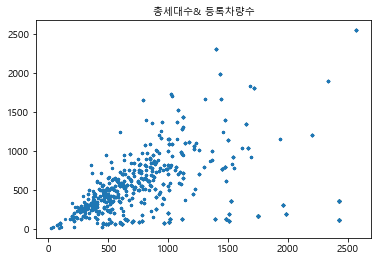

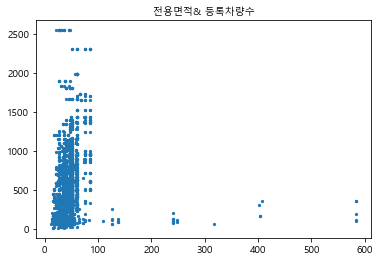

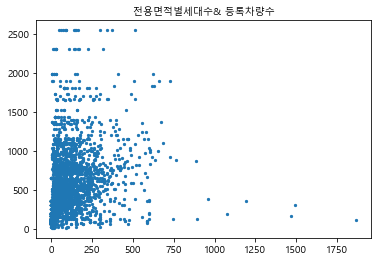

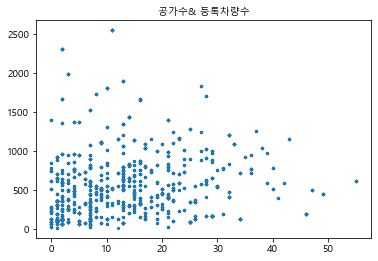

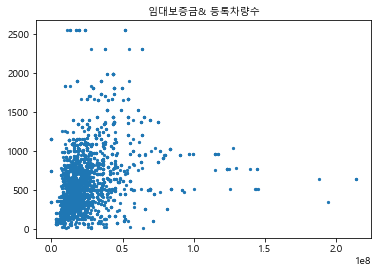

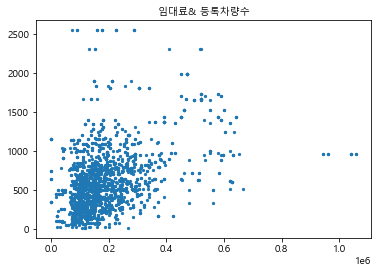

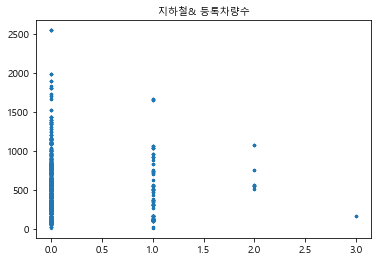

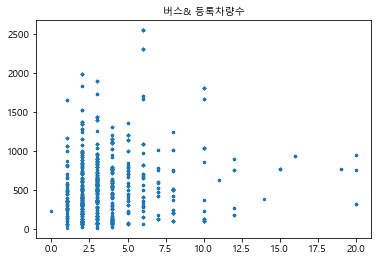

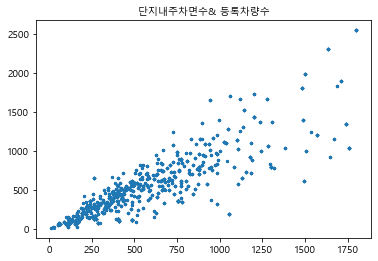

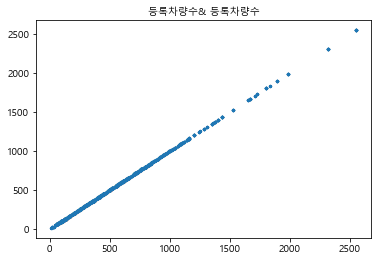

In [31]:
for column_name in train.columns:
    try:
        if train[column_name].dtype == 'int64' or train[column_name].dtype == 'float64':
            plt.scatter(train[column_name], train['등록차량수'],s=5)
            plt.title(column_name+'& 등록차량수', fontsize=10)
            plt.show()
    except:
        pass

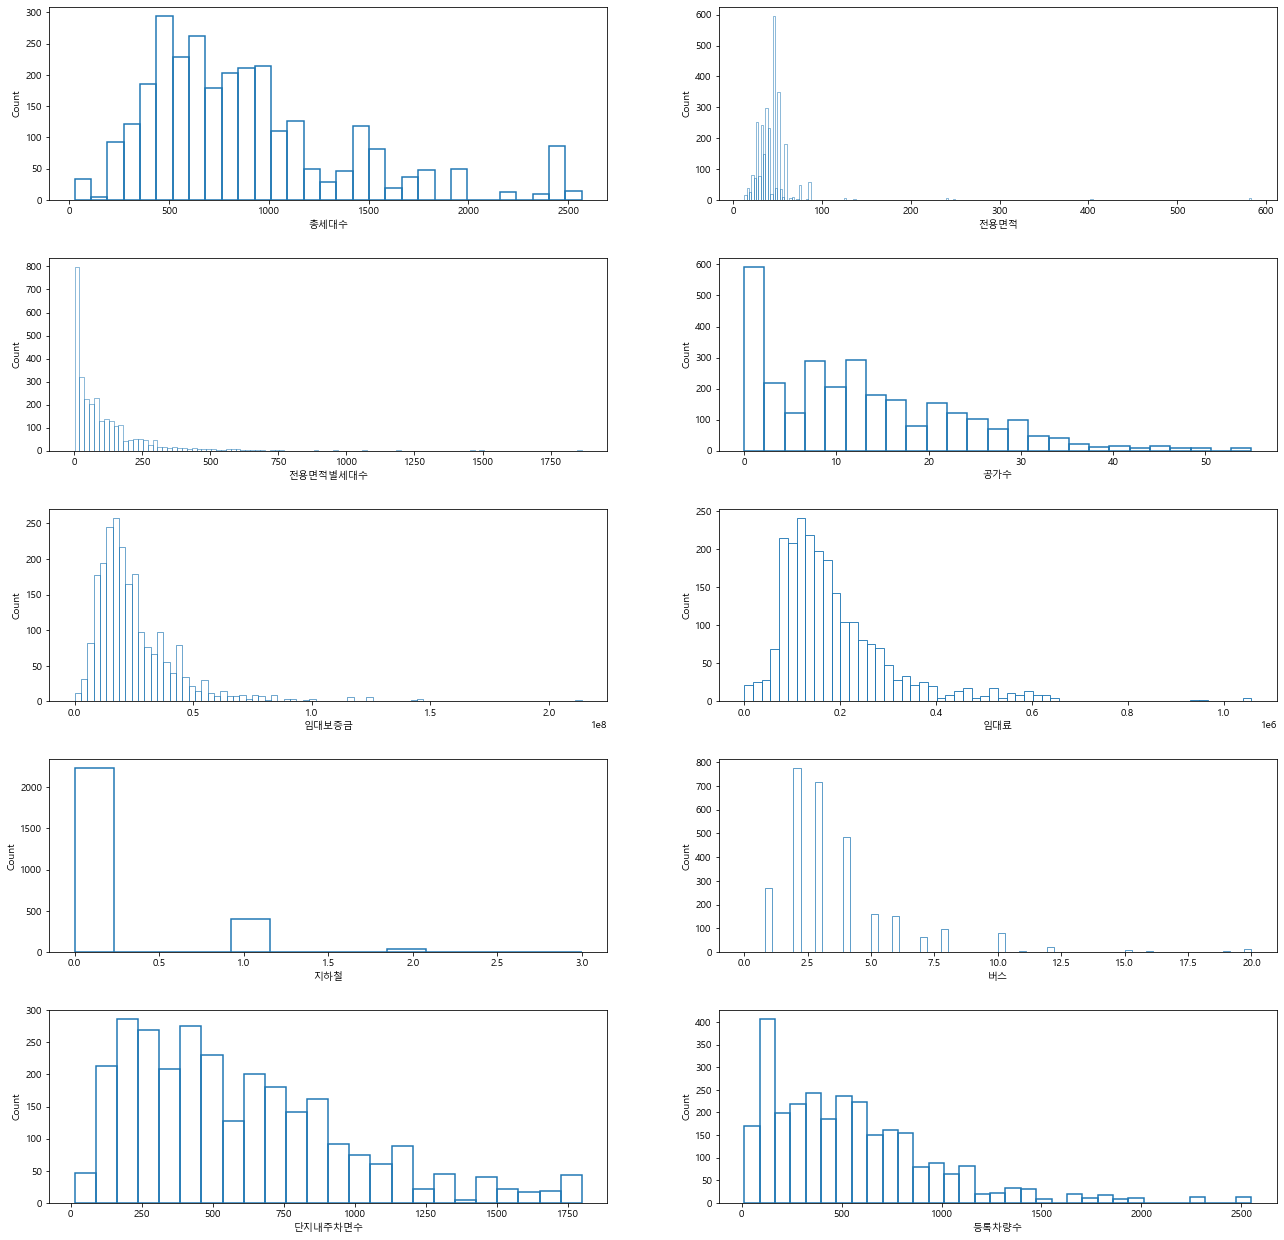

In [32]:
import seaborn as sns

numeric_cols = []
for col in train.columns:
    if train[col].dtypes != 'object':
        numeric_cols.append(col)
        
fig = plt.figure(figsize=(22, 22))
for i, n in enumerate(numeric_cols):
    plt.subplot(5, 2, i+1)
    plt.subplots_adjust(hspace=0.3)
    sns.histplot(train[n],fill=False)

In [33]:
np.percentile(train['전용면적'],[0,25,50,75,100], interpolation = 'nearest')

array([ 12.62,  32.1 ,  39.84,  51.05, 583.4 ])

In [34]:
train.corr()

,총세대수,전용면적,전용면적별세대수,공가수,임대보증금,임대료,지하철,버스,단지내주차면수,등록차량수
총세대수,1.000000,0.037488,0.099209,0.069985,0.079924,0.068453,0.215184,-0.001086,0.520272,0.326923
전용면적,0.037488,1.000000,-0.033365,-0.079302,0.494263,0.722745,-0.009058,-0.004398,0.060190,0.106366
전용면적별세대수,0.099209,-0.033365,1.000000,0.162760,-0.103063,-0.054747,-0.057614,0.045899,0.288788,0.254948
공가수,0.069985,-0.079302,0.162760,1.000000,0.074191,-0.170950,-0.096291,0.043096,0.303954,0.130775
임대보증금,0.079924,0.494263,-0.103063,0.074191,1.000000,0.500130,0.049818,0.130887,0.216394,0.267389
임대료,0.068453,0.722745,-0.054747,-0.170950,0.500130,1.000000,0.090041,0.053030,0.261997,0.410607
지하철,0.215184,-0.009058,-0.057614,-0.096291,0.049818,0.090041,1.000000,0.096585,-0.047127,-0.101792
버스,-0.001086,-0.004398,0.045899,0.043096,0.130887,0.053030,0.096585,1.000000,0.078828,0.110977
단지내주차면수,0.520272,0.060190,0.288788,0.303954,0.216394,0.261997,-0.047127,0.078828,1.000000,0.856549
등록차량수,0.326923,0.106366,0.254948,0.130775,0.267389,0.410607,-0.101792,0.110977,0.856549,1.000000


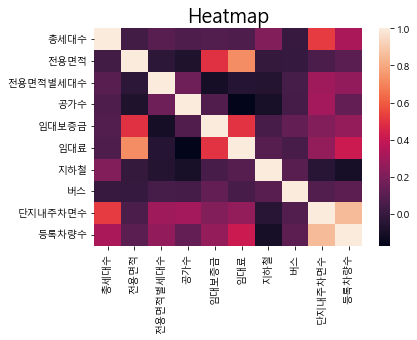

In [35]:
ax = sns.heatmap(train.corr())

plt.title('Heatmap', fontsize=20)

plt.show() 

In [36]:
train.groupby(['단지코드','임대건물구분'])[['임대건물구분']].count()

임대건물구분
단지코드  임대건물구분        
C1000 아파트          7
C1004 상가          17
      아파트          2
C1005 아파트          3
C1013 아파트          5
...              ...
C2663 아파트          6
C2666 아파트          6
C2670 아파트          5
C2680 아파트          3
C2692 아파트          5

[444 rows x 1 columns]

In [37]:
train.drop(columns=['임대보증금','임대료'],axis = 1,inplace=True)

In [38]:
train.head()

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,지하철,버스,단지내주차면수,등록차량수
0,C2515,545,아파트,경상남도,국민임대,33.48,276,17.0,0.0,3.0,624.0,205.0
1,C2515,545,아파트,경상남도,국민임대,39.60,60,17.0,0.0,3.0,624.0,205.0
2,C2515,545,아파트,경상남도,국민임대,39.60,20,17.0,0.0,3.0,624.0,205.0
3,C2515,545,아파트,경상남도,국민임대,46.90,38,17.0,0.0,3.0,624.0,205.0
4,C2515,545,아파트,경상남도,국민임대,46.90,19,17.0,0.0,3.0,624.0,205.0


---

In [39]:
train = pd.read_csv('train.csv')

In [40]:
train.sort_values(by='단지코드' ,ascending=True)

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수
1805,C1000,566,아파트,충청북도,국민임대,39.93,75,10.0,A,10803000,96030,0.0,1.0,438.0,481.0
1803,C1000,566,아파트,충청북도,국민임대,39.57,318,10.0,A,10803000,96030,0.0,1.0,438.0,481.0
1806,C1000,566,아파트,충청북도,국민임대,46.70,36,10.0,A,14404000,129640,0.0,1.0,438.0,481.0
1807,C1000,566,아파트,충청북도,국민임대,46.90,36,10.0,A,14404000,129640,0.0,1.0,438.0,481.0
1808,C1000,566,아파트,충청북도,국민임대,51.93,60,10.0,A,15604000,150040,0.0,1.0,438.0,481.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1963,C2692,499,아파트,경상북도,국민임대,36.64,277,19.0,A,10242000,82600,0.0,2.0,409.0,437.0
1965,C2692,499,아파트,경상북도,국민임대,46.49,60,19.0,A,18173000,132170,0.0,2.0,409.0,437.0
1966,C2692,499,아파트,경상북도,국민임대,46.49,45,19.0,A,18173000,132170,0.0,2.0,409.0,437.0
1967,C2692,499,아파트,경상북도,국민임대,51.59,60,19.0,A,22138000,159700,0.0,2.0,409.0,437.0


In [41]:
(train.groupby('단지코드')[['등록차량수']].sum()/train.groupby('단지코드')[['등록차량수']].count()).sort_index(ascending=True)

,등록차량수
단지코드,
C1000,481.0
C1004,93.0
C1005,376.0
C1013,1665.0
C1014,708.0
...,...
C2663,652.0
C2666,701.0
C2670,435.0


In [42]:
def preprocessing_df(df):
    df.rename(columns = {'도보 10분거리 내 지하철역 수(환승노선 수 반영)':'지하철','도보 10분거리 내 버스정류장 수':'버스'},inplace=True)
    df.drop(columns=['임대보증금','임대료','자격유형','임대건물구분'],axis = 1,inplace=True)
    return df

In [43]:
preprocessing_df(train)

,단지코드,총세대수,지역,공급유형,전용면적,전용면적별세대수,공가수,지하철,버스,단지내주차면수,등록차량수
0,C2483,900,경상북도,국민임대,39.72,134,38.0,0.0,3.0,1425.0,1015.0
1,C2483,900,경상북도,국민임대,39.72,15,38.0,0.0,3.0,1425.0,1015.0
2,C2483,900,경상북도,국민임대,51.93,385,38.0,0.0,3.0,1425.0,1015.0
3,C2483,900,경상북도,국민임대,51.93,15,38.0,0.0,3.0,1425.0,1015.0
4,C2483,900,경상북도,국민임대,51.93,41,38.0,0.0,3.0,1425.0,1015.0
...,...,...,...,...,...,...,...,...,...,...,...
2947,C2532,239,강원도,국민임대,49.20,19,7.0,0.0,1.0,166.0,146.0
2948,C2532,239,강원도,국민임대,51.08,34,7.0,0.0,1.0,166.0,146.0
2949,C2532,239,강원도,국민임대,51.73,34,7.0,0.0,1.0,166.0,146.0
2950,C2532,239,강원도,국민임대,51.96,114,7.0,0.0,1.0,166.0,146.0


In [44]:
지역별_등록차량수_비율 = (train.groupby(['지역'])[['등록차량수']].sum())/(train.groupby(['지역'])[['등록차량수']].sum()['등록차량수'].sum())*100
지역별_등록차량수_비율.rename(columns = {'등록차량수':'지역별_등록차량수_비율'},inplace=True)
지역별_등록차량수_비율

,지역별_등록차량수_비율
지역,
강원도,4.393635
경기도,29.868691
경상남도,9.250222
경상북도,4.614884
광주광역시,6.244841
대구광역시,5.391979
대전광역시,8.618488
부산광역시,6.283269
서울특별시,3.417318


In [48]:
지역_비율 = (train.groupby(['지역'])['총세대수'].count())/(train.groupby(['지역'])['총세대수'].count().sum())*100
지역_비율.rename({'지역':'지역_비율'},inplace=True)
지역_비율

지역
강원도         6.334688
경기도        21.036585
경상남도       12.500000
경상북도        4.031165
광주광역시       4.776423
대구광역시       3.455285
대전광역시       9.010840
부산광역시      11.111111
서울특별시       2.168022
세종특별자치시     1.592141
울산광역시       1.219512
전라남도        5.115176
전라북도        3.692412
제주특별자치도     3.082656
충청남도        5.352304
충청북도        5.521680
Name: 총세대수, dtype: float64

In [ ]:
공급유형별_등록차량수_비율 = (train.groupby(['공급유형'])[['등록차량수']].sum())/(train.groupby(['공급유형'])[['등록차량수']].sum()['등록차량수'].sum())*100
공급유형별_등록차량수_비율.rename(columns = {'공급유형':'공급유형별_등록차량수_비율'},inplace=True)
공급유형별_등록차량수_비율

In [ ]:
train = pd.merge(train,지역별_등록차량수_비율, on='지역')
train = pd.merge(train,공급유형별_등록차량수_비율, on='공급유형')

train.head()

In [ ]:
train = pd.read_csv('train.csv')

In [ ]:
def preprocessing_train(df):
    # 오류 단지코드가 존재하는 행들을  사전에 제거
    df_error = ['C2085', 'C1397', 'C2431', 'C1649', 'C1036', 'C1095', 'C2051', 'C1218', 'C1894', 'C2483', 'C1502', 'C1988']
    df = df[~df['단지코드'].isin(df_error)].reset_index(drop=True)
    df.rename(columns = {'도보 10분거리 내 지하철역 수(환승노선 수 반영)':'지하철','도보 10분거리 내 버스정류장 수':'버스'},inplace=True)
    df.drop(columns=['임대보증금','임대료','자격유형','임대건물구분'],axis = 1,inplace=True)
    지역별_등록차량수_비율 = (df.groupby(['지역'])[['등록차량수']].sum())/(df.groupby(['지역'])[['등록차량수']].sum()['등록차량수'].sum())*100
    지역별_등록차량수_비율.rename(columns = {'등록차량수':'지역별_등록차량수_비율'},inplace=True)
    공급유형별_등록차량수_비율 = (df.groupby(['공급유형'])[['등록차량수']].sum())/(df.groupby(['공급유형'])[['등록차량수']].sum()['등록차량수'].sum())*100
    공급유형별_등록차량수_비율.rename(columns = {'등록차량수':'공급유형별_등록차량수_비율'},inplace=True)
    df = pd.merge(df,지역별_등록차량수_비율, on='지역')
    df = pd.merge(df,공급유형별_등록차량수_비율, on='공급유형')
    df.drop(columns=['지역','공급유형','단지코드'],axis = 1,inplace=True)
    return df

In [ ]:
train = preprocessing_train(train)
train

In [ ]:
import seaborn as sns

fig = plt.figure(figsize=(22, 22))
for i, n in enumerate(train.columns):
    plt.subplot(5, 2, i+1)
    plt.subplots_adjust(hspace=0.3)
    sns.histplot(train[n],fill=False)

In [ ]:
train.corr()

In [ ]:
np.percentile(train['전용면적'],[0,25,50,75,100], interpolation = 'nearest')

In [ ]:
fig, ax = plt.subplots()

ax.boxplot([train['전용면적']], notch=True, whis=2.5, vert=False)

plt.show()

In [ ]:
np.percentile(train['전용면적별세대수'],[0,25,50,75,100], interpolation = 'nearest')

---

In [ ]:
test = pd.read_csv('train.csv')

In [ ]:
def preprocessing_test(df):
    # 오류 단지코드가 존재하는 행들을  사전에 제거
    df_error = ['C2085', 'C1397', 'C2431', 'C1649', 'C1036', 'C1095', 'C2051', 'C1218', 'C1894', 'C2483', 'C1502', 'C1988']
    df = df[~df['단지코드'].isin(df_error)].reset_index(drop=True)
    df.rename(columns = {'도보 10분거리 내 지하철역 수(환승노선 수 반영)':'지하철','도보 10분거리 내 버스정류장 수':'버스'},inplace=True)
    df.drop(columns=['임대보증금','임대료','자격유형','임대건물구분'],axis = 1,inplace=True)
    지역별_등록차량수_비율 = (df.groupby(['지역'])[['등록차량수']].sum())/(df.groupby(['지역'])[['등록차량수']].sum()['등록차량수'].sum())*100
    지역별_등록차량수_비율.rename(columns = {'등록차량수':'지역별_등록차량수_비율'},inplace=True)
    공급유형별_등록차량수_비율 = (df.groupby(['공급유형'])[['등록차량수']].sum())/(df.groupby(['공급유형'])[['등록차량수']].sum()['등록차량수'].sum())*100
    공급유형별_등록차량수_비율.rename(columns = {'등록차량수':'공급유형별_등록차량수_비율'},inplace=True)
    df = pd.merge(df,지역별_등록차량수_비율, on='지역')
    df = pd.merge(df,공급유형별_등록차량수_비율, on='공급유형')
    df.drop(columns=['지역','공급유형','단지코드'],axis = 1,inplace=True)
    return df

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
from sklearn.metrics import explained_variance_score,mean_absolute_error,r2_score

In [ ]:
from time import time

from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

In [ ]:
regressors = [
    KNeighborsRegressor(),
    GradientBoostingRegressor(),
    KNeighborsRegressor(),
    ExtraTreesRegressor(),
    RandomForestRegressor(),
    DecisionTreeRegressor(),
    LinearRegression(),
    Lasso(),
    Ridge()
]

In [ ]:
head = 10
y = train['등록차량수']
for model in regressors[:head]:
    start = time()
    model.fit(train.drop('등록차량수'),y)
    train_time = time() - start
    start = time()
    y_pred = model.predict(test)
    predict_time = time()-start    
    print(model)
    print("\tTraining time: %0.3fs" % train_time)
    print("\tPrediction time: %0.3fs" % predict_time)
    print("\tExplained variance:", explained_variance_score(test, y_pred))
    print("\tMean absolute error:", mean_absolute_error(test, y_pred))
    print("\tR2 score:", r2_score(test, y_pred))
    print()